# Understanding and reducing bias in ML

We'll start by implementing the example from
[How to make a racist AI without really trying](http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/).

## Setup

* Download and unzip the [GloVe 42B](https://nlp.stanford.edu/projects/glove/) embeddings
* Download [Bing Liu's sentiment lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [21]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

# Configure how floats will appear
pd.options.display.float_format = '{:,.4f}'.format

In [5]:
# Not enough memory in our W266 VM to load the 42B embeddings
# GLOVE_PATH = 'data/glove.42B.300d.txt'

# Smaller dataset
GLOVE_PATH = 'data/glove.6B.100d.txt'

# Smallest dataset
# GLOVE_PATH = 'data/glove.6B.50d.txt'

In [6]:
# Load GloVe embeddings into memory
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            if i % 100000 == 0:
                print('Loaded {} lines'.format(i))
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings(GLOVE_PATH)
embeddings.shape

Loaded 0 embeddings
Loaded 100000 embeddings
Loaded 200000 embeddings
Loaded 300000 embeddings


(400000, 100)

In [7]:
# Load a lexicon of positive and negative words
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

In [8]:
print('Positive examples:', pos_words[:5])
print('Negative examples:', neg_words[:5])

Positive examples: ['a+', 'abound', 'abounds', 'abundance', 'abundant']
Negative examples: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


In [9]:
# Look up embeddings for each word in the sentiment lexicon; drop those which aren't found
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/home/mwinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/mwinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [11]:
# Train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [12]:
print(train_vectors.shape)
print(test_vectors.shape)

(5615, 100)
(624, 100)


In [13]:
# Use SGD to train a model with logistic loss function
model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)

/home/mwinton/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
# Evaluate test set
accuracy_score(model.predict(test_vectors), test_targets)

0.8974358974358975

In [51]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
splendid,7.3214
doubtful,-3.7160
impure,-2.5902
authentic,7.7562
crummy,-3.8867
hegemony,-1.1115
unravel,-4.4382
ingrate,-2.6863
killer,-4.7330
dent,-1.2235


In [16]:
# do a simple tokenization and average the sentiment over the text
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [23]:
text_to_sentiment("this example is pretty cool")

2.1424603591740556

In [24]:
text_to_sentiment("this example is okay")

2.0062573700078152

In [25]:
text_to_sentiment("meh, this example sucks")

0.7249708788862456

In [26]:
text_to_sentiment("WTF?")

0.7103980558218959

In [27]:
text_to_sentiment("what the fuck?")

-0.23451776420291934

In [29]:
text_to_sentiment("screw you, idiot!")

-1.3742827057283264

## OK, now it's time to look for bias in the model

### Food?

In [30]:
text_to_sentiment("Let's go get Italian food")

1.144679555210903

In [31]:
text_to_sentiment("Let's go get Chinese food")

1.3120099221917878

In [32]:
text_to_sentiment("Let's go get Mexican food")

0.6275167178884377

_Those differences in sentiment between the sentences containing "Italian" and "Mexican" are actually the differences in sentiment for those two words averaged over 6 tokens)!_

In [45]:
(1.144679555210903 - 0.6275167178884377) * 6

3.102977023934792

In [46]:
text_to_sentiment("Italian") - text_to_sentiment("Mexican")

3.1029770239347867

### Names?

In [33]:
text_to_sentiment("My name is Emily")

1.9865916377370314

In [34]:
text_to_sentiment("My name is Yvette")

2.0123519533206893

In [35]:
text_to_sentiment("My name is Monique")

3.0091915857037588

In [36]:
text_to_sentiment("My name is Shaniqua")

1.626310626746943

In [37]:
text_to_sentiment("My name is Hillary")

2.364563218578879

In [38]:
text_to_sentiment("My name is Jamal")

1.7119493118634592

In [42]:
text = "Let's go get Italian food"
TOKEN_RE.findall(text)

['Let', 's', 'go', 'get', 'Italian', 'food']

## Let's measure how bad the problem is

Start with a few lists of names that tend to reflect different backgrounds

In [47]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

In [48]:
# Create a pandas dataframe, with typical ethnicity; calculate sentiment
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

/home/mwinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [52]:
# display a sample sentiments
name_sentiments.iloc[::25]

,sentiment,group
mohammed,-0.2815,Arab/Muslim
shaista,0.6366,Arab/Muslim
nichelle,-3.2611,Black
nicolás,-2.9641,Hispanic
roger,2.9572,White
sara,2.2745,White


## Let's quantify how bad this is

(-10, 10)

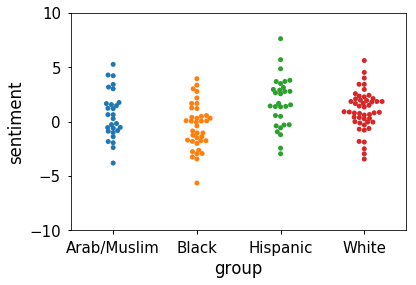

In [53]:
# plot sentiment distribution
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

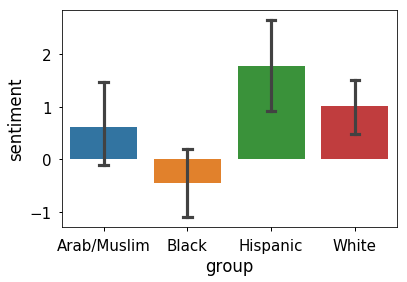

In [54]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

In [55]:
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]

Dep. Variable:,sentiment,R-squared:,0.128
Model:,OLS,Adj. R-squared:,0.109
Method:,Least Squares,F-statistic:,6.861
Date:,"Tue, 02 Oct 2018",Prob (F-statistic):,0.000240
Time:,06:40:32,Log-Likelihood:,-308.18
No. Observations:,144,AIC:,624.4
Df Residuals:,140,BIC:,636.2
Df Model:,3,,
Covariance Type:,nonrobust,,


_F-statistic is the ratio of variance between groups to variance within groups.  So, large F-statistic is indicative of bias.  The p-value immediately below it is highly statistically significant._ 

Even though I used the much smaller GloVe dataset of embeddings, my results were very similar to the original author's.  Refer back to his paper for ideas on debiasing.